# Vehicle Detection

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
import pickle
import cv2

Prepare data for classifier

In [2]:

cars = glob.glob('vehicles/*/*.png')
notcars = glob.glob('non-vehicles/*/*.png')

print('* images analysis ',
      len(cars), ' cars and',
      len(notcars), ' non-cars')


* images analysis  8792  cars and 9209  non-cars


In [3]:
# Define a function to return some characteristics of the dataset
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict




In [4]:
data_info = data_look(cars, notcars)
print('* function returned a count of',
      data_info["n_cars"], ' cars and',
      data_info["n_notcars"], ' non-cars')
print('* image size: ', data_info["image_shape"], ' and data type:',
      data_info["data_type"])

* function returned a count of 8792  cars and 9209  non-cars
* image size:  (64, 64, 3)  and data type: float32


In [5]:
# sample_size = 500
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

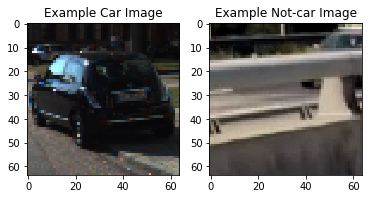

In [6]:
# Read in car / not-car images
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

In [7]:
##Extract Feastures Functions

def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
    # Return list of feature vectors
    return features

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [8]:
car_features = extract_features(cars, cspace=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel)

notcar_features = extract_features(notcars, cspace=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel)

/home/machinelearn/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [9]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
print(X.shape)

(18001, 4140)


In [10]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

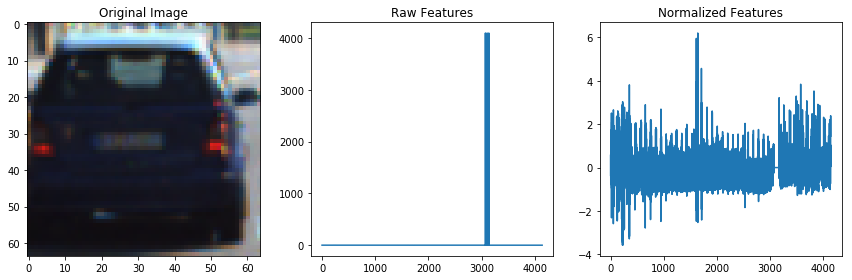

In [11]:
car_ind = np.random.randint(0, len(cars))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(mpimg.imread(cars[car_ind]))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

/home/machinelearn/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


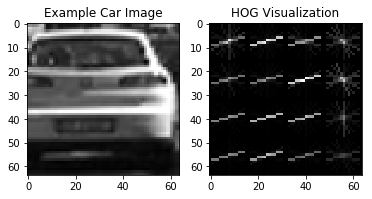

In [12]:
# Read in car / not-car images
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient,
                                             pix_per_cell, cell_per_block,
                                             vis=True, feature_vec=False)
fig = plt.figure()
plt.subplot(121)
plt.imshow(gray, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

plt.show()

In [13]:
print('Using:', orient, 'orientations', pix_per_cell, 'pixels per cell and', cell_per_block, 'cells per block')


Using: 9 orientations 16 pixels per cell and 2 cells per block


Train classifier

In [14]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time

# traning_model.color_classifier(X=scaled_X, Y=y, spatial=spatial, histbin=histbin)
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)
    
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t = time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these', n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2 - t, 5), 'Seconds to predict', n_predict, 'labels with SVC')    

pickle_dist = dict({'svc': svc, 'scaler': X_scaler, 'orient': orient, 'pix_per_cell': pix_per_cell,
                   'cell_per_block': cell_per_block, 'spatial_size': spatial_size, 'hist_bins': hist_bins})
pickle.dump(pickle_dist, open("svc_pickle_final.p", "wb"))

Feature vector length: 4140
24.4 Seconds to train SVC...
Test Accuracy of SVC =  0.9833
My SVC predicts:  [ 1.  0.  0.  0.  0.  0.  0.  1.  1.  1.]
For these 10 labels:  [ 1.  0.  0.  0.  0.  0.  0.  1.  1.  1.]
0.00292 Seconds to predict 10 labels with SVC


In [15]:


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [16]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
#         win = (window[0][1],window[1][1], window[0][0],window[1][0])
        #3) Extract the test window from original image - resize it to 64x64
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [18]:
image = mpimg.imread('test_images/test6.jpg')
draw_image = np.copy(image)
image = image.astype(np.float32)/255.0
windows = []

#Windows1
y_start_stop1 = [380, 580]
x_start_stop1 = [200,1200] 
win_size1 = (96,96)
windows.extend(slide_window(image, x_start_stop=x_start_stop1, y_start_stop=y_start_stop1, 
                    xy_window=win_size1, xy_overlap=(0.65, 0.65)))

# # Windows2
y_start_stop2 = [400,592]
x_start_stop2 = [0,1280]
win_size2 = (140,140)
windows.extend(slide_window(image, x_start_stop=x_start_stop2, y_start_stop=y_start_stop2, 
                    xy_window=win_size2, xy_overlap=(0.55, 0.55)))

# Windows3
y_start_stop3 = [410,680]
x_start_stop3 = [0,1280] 
win_size3 = (192,192)
windows.extend(slide_window(image, x_start_stop=x_start_stop3, y_start_stop=y_start_stop3, 
                    xy_window=win_size3, xy_overlap=(0.55, 0.55)))

# Windows4
y_start_stop4 = [380,508]
x_start_stop4 = [300,1200] 
win_size4 = (64,64)
windows.extend(slide_window(image, x_start_stop=x_start_stop4, y_start_stop=y_start_stop4, 
                    xy_window=win_size4, xy_overlap=(0.6, 0.6)))

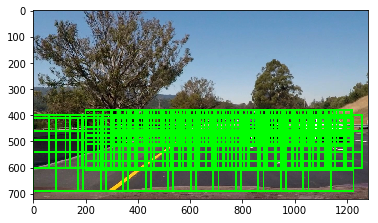

In [19]:

# window_img = draw_boxes(draw_image, windows, color=(0, 100, 200), thick=6)
window_img = draw_boxes(draw_image, windows, color=(0, 255, 0), thick=6)

plt.imshow(window_img)
plt.show()

In [20]:
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    car_colors = [(0,0,255),(0,255,0),(255,0,0),(0,100,200),(200,100,0),(200,0,100),(100,100,100)]
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        if check_box(bbox)== True:
            cv2.rectangle(img, bbox[0], bbox[1], car_colors[(car_number-1)%5], 5)
    # Return the image
    return img


def check_box(bbox):
    min_size = 64
    if (bbox[1][0] - bbox [0][0]) >= min_size and (bbox[1][1] - bbox [0][1]) >= min_size:
        return True
    else:
        return False

class heatmap_obj:
    def __init__(self,image,num_frames):
        self.heatmap = np.zeros_like(image[:,:,0])
        self.iteration = 0
        self.heatmaps = []
        self.cur_heatmap = np.zeros_like(image[:,:,0])
        self.threshmap = np.zeros_like(image[:,:,0])
        self.num_history = num_frames
        
    def add_heat(self, bbox_list):
        # Iterate through list of bboxes
        self.iteration += 1
        self.cur_heatmap = np.zeros_like(image[:,:,0])
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
#             self.cur_heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
            self.cur_heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] = 1
            
        # Return updated heatmap
        self.update_hms()
        return None
    
    def apply_threshold(self, threshold):
        # Zero out pixels below the threshold
        self.threshmap = np.copy(self.heatmap)
        self.threshmap[self.heatmap <= threshold] = 0
        # Return thresholded map
        return None
    
    def update_hms(self):
#         num_history = 36
        self.heatmaps.append(self.cur_heatmap)
        if len(self.heatmaps) > self.num_history:
            self.heatmaps.pop(0)
        self.heatmap = sum(self.heatmaps)
def hard_negative_mining(image,labels,hot_windows):
    size = (64,64) #training image size
    picture_boxes = overlap_labels(labels,hot_windows)
    global picture_index
    for pic_box in picture_boxes:
#         (left,bot),(right,top)
        pic = image[pic_box[0][1]:pic_box[1][1], pic_box[0][0]:pic_box[1][0], :]
        out_img = cv2.resize(pic, size)
        mpimg.imsave("non-vehicles/RE2/out"+str(picture_index)+".png", out_img)
#         mpimg.imsave("out.png",out_img)
        picture_index += 1
#         break
    return None



def overlap_labels(labels,hot_windows):

    label_boxes=[]
    #save all the label boxes
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        label_boxes.append(bbox)
    
    #check if windows overlap label boxes
    non_vehicle_boxes = [] #list of boxes that don't overlap the labels
    
    for window in hot_windows:
#         window_list.append(((startx, starty), (endx, endy)))
#                 (left,bot),(right,top)

        window_in_box = False

        #if the window overlaps the detection box, flag it, don't append to non-vehicles
        for box in label_boxes:
            if overlap(window,box) == True:
                window_in_box = True
                break
            
        if window_in_box == False:
            non_vehicle_boxes.append(window)
            
    return non_vehicle_boxes
#poorly tested manually

                
def overlap(r1,r2):
    #Check if 2 rectangles are overlappng
    #http://codereview.stackexchange.com/questions/31352/overlapping-rectangles
    '''Overlapping rectangles overlap both horizontally & vertically
    '''
    hoverlaps = True
    voverlaps = True
#     if (r1.left > r2.right) or (r1.right < r2.left):
    if (r1[0][0] > r2[1][0]) or (r1[1][0] < r2[0][0]):
        hoverlaps = False
#     if (r1.top < r2.bottom) or (r1.bottom > r2.top):
    if (r1[1][1] < r2[0][1]) or (r1[0][1] > r2[1][1]):
        voverlaps = False
    return hoverlaps and voverlaps
#Tested manually.

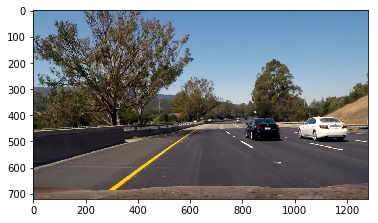

In [21]:

# image = mpimg.imread('test_images/rtest0.png')
image = mpimg.imread('test_images/test6.jpg')
draw_image = np.copy(image)
image = image.astype(np.float32)/255.0

plt.imshow(draw_image)

In [22]:

#create a heatmap object

threshold_detections = 3
num_frames = 36
hmt = heatmap_obj(image,36)

/home/machinelearn/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
/home/machinelearn/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/home/machinelearn/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in multiply


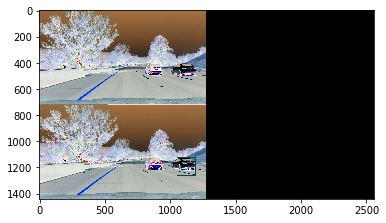

In [23]:
#Script version of the P5 function for debug

picture_index = 0
image = mpimg.imread('test_images/test6.jpg')
cut_image = np.copy(image)
draw_image = np.copy(image)
image = image.astype(np.float32)/255.0

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

# window_img = draw_boxes(draw_image, windows, color=(0, 100, 200), thick=6)
window_img = draw_boxes(draw_image, hot_windows, color=(0, 180, 200), thick=6)

#add heat to the windows
hmt.add_heat(hot_windows)

#apply the threshold
hmt.apply_threshold(threshold_detections)

#find connecting regions
labels = label(hmt.threshmap)

#draw the images
draw_img = draw_labeled_bboxes(draw_image, labels)

#generate new training data
hard_negative_mining(image,labels,hot_windows)

#scale the heatmap
heatmap = hmt.heatmap*(255.0/hmt.heatmap.max())
heatmap_out = np.dstack((heatmap,heatmap,heatmap))

#scale the thresholded heatmap
threshmap = hmt.threshmap*(255.0/hmt.threshmap.max())
threshmap_out = np.dstack((threshmap,threshmap,threshmap))

#put all images together 

plt.imshow(np.concatenate((np.concatenate((draw_img,heatmap_out),axis=1),np.concatenate((window_img,threshmap_out),axis=1))
                          ,axis=0))

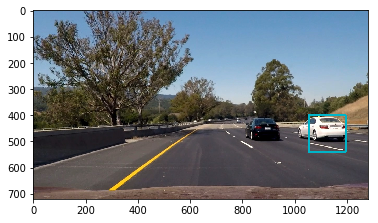

In [24]:
plt.imshow(window_img)

In [25]:
picture_index = 0
negative_mining = False
threshold_detections = 3
num_frames = 12
hm = heatmap_obj(np.zeros_like(image),num_frames)
def vehicle_detection(image):
    draw_image = np.copy(image)
    cut_image = np.copy(image)
    image = image.astype(np.float32)/255.0
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
    
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 255, 0), thick=6)
    
    #add heat to the windows
    hm.add_heat(hot_windows)
    
    #apply the threshold
    hm.apply_threshold(threshold_detections)
    
    #find connecting regions
    labels = label(hm.threshmap)
    
    #draw the images
    draw_img = draw_labeled_bboxes(draw_image, labels)
    
    #generate new training data
    if hm.iteration > 44 and negative_mining ==True:
        hard_negative_mining(cut_image,labels,hot_windows)
    
    #scale the heatmap
    heatmap = hm.heatmap*(255.0/hm.heatmap.max())
    heatmap_out = np.dstack((heatmap,heatmap,heatmap))
    
    #scale the thresholded heatmap
    threshmap = hm.threshmap*(255.0/hm.threshmap.max())
    threshmap_out = np.dstack((threshmap,threshmap,threshmap))
    
    #put all images together 
    return (np.concatenate((np.concatenate((draw_img,heatmap_out),axis=1),np.concatenate((window_img,threshmap_out),axis=1))
                          ,axis=0))

/home/machinelearn/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
/home/machinelearn/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
/home/machinelearn/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in multiply


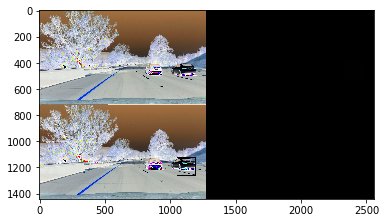

In [26]:
image = mpimg.imread('test_images/test6.jpg')
out = vehicle_detection(image)

plt.imshow(out)

In [27]:
from moviepy.editor import VideoFileClip
proj5_output = 'test_video_out.mp4'
driving_clip = VideoFileClip('test_video.mp4')
out_clip = driving_clip.fl_image(vehicle_detection)
%time out_clip.write_videofile(proj5_output, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:41<00:01,  1.05s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 37.4 s, sys: 2.32 s, total: 39.8 s
Wall time: 44 s


In [28]:
proj5_output = 'project_video_out.mp4'
driving_clip = VideoFileClip('project_video.mp4')
out_clip = driving_clip.fl_image(vehicle_detection)
%time out_clip.write_videofile(proj5_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [24:25<00:01,  1.15s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 22min 44s, sys: 1min 17s, total: 24min 2s
Wall time: 24min 27s
